Let's assume that you have a panel dataset which shows **day-by-day** for the previous **year**:
1. Number of users in each of 200 geo units
2. Number of buyers in each of 200 geo units

for the three groups of users:
 - (1) only Facebook users (never seen on INST for the entire year)
 - (2) only Instagram users (never seen on Fb for the entire year)
 - (3) users of both Fb and INST

In [12]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(1) # to make it reproducible

# -----------------------------
# 1) Simulate dataset
# -----------------------------

# Cities and number of users
cities = [f"city_{i:03d}" for i in range(200)]
users_total = rng.integers(30_000, 300_000, size=len(cities))
city_df = pd.DataFrame({"city": cities, "users_total": users_total})

# Market assumption
p_fb_only_mean = 0.25
p_ig_only_mean = 0.10
p_both_mean    = 0.40

# Generate proportion for each city
p_fb_only = np.clip(rng.normal(p_fb_only_mean, 0.02, len(cities)), 0, 1)
p_ig_only = np.clip(rng.normal(p_ig_only_mean, 0.02, len(cities)), 0, 1)
p_both    = np.clip(rng.normal(p_both_mean,    0.02, len(cities)), 0, 1)

# Checking proportions
row_sum = p_fb_only + p_ig_only + p_both
too_high = row_sum > 1.0
p_fb_only[too_high] /= row_sum[too_high]
p_ig_only[too_high] /= row_sum[too_high]
p_both[too_high]    /= row_sum[too_high]

# Calculate users per segment
city_df["fb_only_users"] = np.rint(city_df["users_total"] * p_fb_only).astype(int)
city_df["ig_only_users"] = np.rint(city_df["users_total"] * p_ig_only).astype(int)
city_df["both_users"]    = np.rint(city_df["users_total"] * p_both).astype(int)
city_df["total_users"]   = city_df[["fb_only_users","ig_only_users","both_users"]].sum(axis=1)

# Note: I'm assuming that the number of users doesn't change over the year

In [14]:
city_df.head()

,city,users_total,fb_only_users,ig_only_users,both_users,total_users
0,city_000,157760,40490,14799,63193,118482
1,city_001,168191,39857,14825,62667,117349
2,city_002,233895,62508,22651,103735,188894
3,city_003,286625,70936,25904,106697,203537
4,city_004,39410,10380,3388,14915,28683


In [16]:
# Generate daily observations
dates = pd.date_range("2024-01-01","2024-12-31",freq="D")
day_to_idx = {d:i for i,d in enumerate(dates)}
t = np.arange(len(dates))

panel = pd.DataFrame([(d,c) for d in dates for c in cities], columns=["date","city"])
panel = panel.merge(city_df[["city","fb_only_users","ig_only_users","both_users","total_users"]], on="city", how="left")

panel["day_idx"] = panel["date"].map(day_to_idx).astype(int)

In [17]:
panel.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx
0,2024-01-01,city_000,40490,14799,63193,118482,0
1,2024-01-01,city_001,39857,14825,62667,117349,0
2,2024-01-01,city_002,62508,22651,103735,188894,0
3,2024-01-01,city_003,70936,25904,106697,203537,0
4,2024-01-01,city_004,10380,3388,14915,28683,0


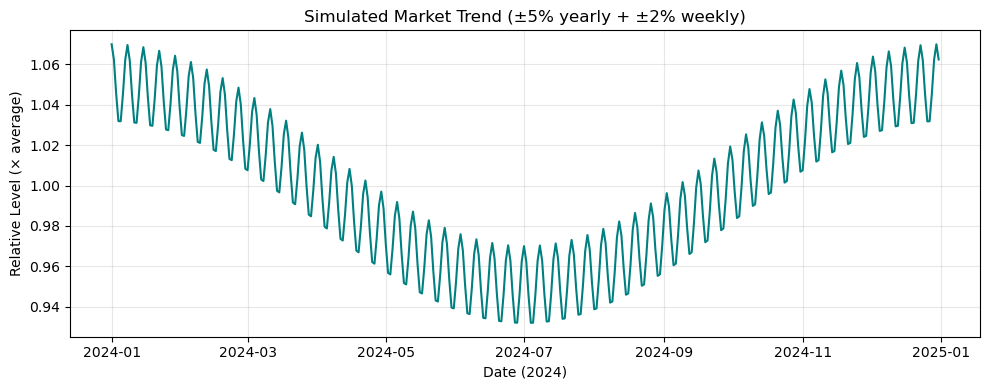

In [21]:
# Simulate a Ups and downs global tendency of number of buyers: yearly ±5% + weekly ±2%
market_trend = 1.0 + 0.05*np.cos(2*np.pi*t/365) + 0.02*np.cos(2*np.pi*t/7)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(dates, market_trend, color="teal")
plt.title("Simulated Market Trend (±5% yearly + ±2% weekly)")
plt.xlabel("Date (2024)")
plt.ylabel("Relative Level (× average)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Adding noise

# per city
geo_mult = np.exp(rng.normal(0, 0.04, len(cities)))
geo_mult_map = dict(zip(cities, geo_mult))

# per city and day
city_day_noise = np.exp(rng.normal(0, 0.02, (len(cities), len(dates))))

# yearly tendency per city
city_slope = rng.normal(0, 0.03, len(cities))
city_slope_map = dict(zip(cities, city_slope))

panel["market_trend"] = market_trend[panel["day_idx"]]
panel["geo_mult"]   = panel["city"].map(geo_mult_map)
panel["day_noise"] = panel.apply(lambda r: city_day_noise[city_to_idx[r["city"]], r["day_idx"]], axis=1)
panel["slope_mult"]   = panel.apply(lambda r: 1.0 + city_slope_map[r["city"]] * year_pos[r["day_idx"]], axis=1)

In [31]:
panel.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx,market_trend,geo_mult,day_noise,slope_mult
0,2024-01-01,city_000,40490,14799,63193,118482,0,1.07,1.033774,0.999033,0.998790
1,2024-01-01,city_001,39857,14825,62667,117349,0,1.07,0.969790,1.023729,1.013706
2,2024-01-01,city_002,62508,22651,103735,188894,0,1.07,0.945220,1.012470,0.986455
3,2024-01-01,city_003,70936,25904,106697,203537,0,1.07,0.948957,1.016384,1.004981
4,2024-01-01,city_004,10380,3388,14915,28683,0,1.07,0.981868,1.007836,1.017351


In [35]:
# Generate buyers

# base buyers rate per segment
p_buy_fb   = 0.00050
p_buy_ig   = 0.00060
p_buy_both = 0.00080

def lam(users, mu, gm, mt, slope, dm):
    return users * mu * gm * mt * slope * dm

lam_fb = lam(users = panel["fb_only_users"].to_numpy(),
            mu = p_buy_fb,
            gm = panel["geo_mult"].to_numpy(),
            mt = panel["market_trend"].to_numpy(),
            slope = panel["slope_mult"].to_numpy(),
            dm = panel["day_noise"].to_numpy())

lam_ig = lam(users = panel["ig_only_users"].to_numpy(),
            mu = p_buy_ig,
            gm = panel["geo_mult"].to_numpy(),
            mt = panel["market_trend"].to_numpy(),
            slope = panel["slope_mult"].to_numpy(),
            dm = panel["day_noise"].to_numpy())

lam_bo = lam(users = panel["both_users"].to_numpy(),
            mu = p_buy_both,
            gm = panel["geo_mult"].to_numpy(),
            mt = panel["market_trend"].to_numpy(),
            slope = panel["slope_mult"].to_numpy(),
            dm = panel["day_noise"].to_numpy())

# Buyers simulated with Poisson(lambda)
panel["fb_only_buyers"] = rng.poisson(lam_fb)
panel["ig_only_buyers"] = rng.poisson(lam_ig)
panel["both_buyers"]    = rng.poisson(lam_bo)

panel["total_buyers"] = panel["fb_only_buyers"] + panel["ig_only_buyers"] + panel["both_buyers"]


In [36]:
panel.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx,market_trend,geo_mult,day_noise,slope_mult,fb_only_buyers,ig_only_buyers,both_buyers,total_buyers
0,2024-01-01,city_000,40490,14799,63193,118482,0,1.07,1.033774,0.999033,0.998790,29,9,40,78
1,2024-01-01,city_001,39857,14825,62667,117349,0,1.07,0.969790,1.023729,1.013706,19,9,68,96
2,2024-01-01,city_002,62508,22651,103735,188894,0,1.07,0.945220,1.012470,0.986455,33,15,88,136
3,2024-01-01,city_003,70936,25904,106697,203537,0,1.07,0.948957,1.016384,1.004981,30,15,82,127
4,2024-01-01,city_004,10380,3388,14915,28683,0,1.07,0.981868,1.007836,1.017351,6,1,18,25


We are about to run a campaign which will reach **~50%** of all users. We want to design an experiment which will allow us to measure:
1. Effect of ads on Facebook only
2. Effect of ads on Instagram only
3. Combined effect of Facebook and Instagram ads.

In [37]:
# -----------------------------
# 1) Experiment
# -----------------------------

# define periods pre/post
cut = pd.Timestamp("2024-07-01")
panel["period"] = np.where(panel["date"] < cut, "pre", "post")

In [38]:
pre = panel[panel["period"] == "pre"].copy()

# Weights per city
users_city = (pre.groupby("city", as_index=False)["total_users"]
                .mean()
                .rename(columns={"total_users": "users_mean"}))

users_city["w"] = users_city["users_mean"] / users_city["users_mean"].sum()


target = 0.50
shuffle_cities = users_city.sample(frac=1.0, random_state=7).reset_index(drop=True) # order randomly the cities
shuffle_cities["cum_w"] = shuffle_cities["w"].cumsum() # calculate the cummulative participation

treated_idx = list(shuffle_cities.index[shuffle_cities["cum_w"] <= target])

In [40]:
treated_cities = set(shuffle_cities.loc[treated_idx, "city"])

assignment = users_city[["city", "w"]].copy()
assignment["treated"] = assignment["city"].isin(treated_cities).astype(int)

coverage = assignment.loc[assignment["treated"] == 1, "w"].sum()
print(f"% Users treated (target 0.50): {coverage:.4f}")

% Users treated (target 0.50): 0.4949


In [41]:
assignment.head()

,city,w,treated
0,city_000,0.004646,0
1,city_001,0.004602,0
2,city_002,0.007407,1
3,city_003,0.007981,0
4,city_004,0.001125,0


In [42]:
# Adjust weight within groups (treated/control)

assignment["w_treated"] = 0.0
assignment.loc[assignment.treated == 1, "w_treated"] = assignment.loc[assignment.treated == 1, "w"] / coverage

assignment["w_control"] = 0.0
assignment.loc[assignment.treated == 0, "w_control"] = assignment.loc[assignment.treated == 0, "w"] / (1-coverage)

# Add new weights to panel
panel_bal = panel.merge(assignment[["city", "w", "treated", "w_treated", "w_control"]],on="city", how="left")

In [43]:
panel_bal.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx,market_trend,geo_mult,day_noise,slope_mult,fb_only_buyers,ig_only_buyers,both_buyers,total_buyers,period,w,treated,w_treated,w_control
0,2024-01-01,city_000,40490,14799,63193,118482,0,1.07,1.033774,0.999033,0.998790,29,9,40,78,pre,0.004646,0,0.000000,0.009199
1,2024-01-01,city_001,39857,14825,62667,117349,0,1.07,0.969790,1.023729,1.013706,19,9,68,96,pre,0.004602,0,0.000000,0.009111
2,2024-01-01,city_002,62508,22651,103735,188894,0,1.07,0.945220,1.012470,0.986455,33,15,88,136,pre,0.007407,1,0.014966,0.000000
3,2024-01-01,city_003,70936,25904,106697,203537,0,1.07,0.948957,1.016384,1.004981,30,15,82,127,pre,0.007981,0,0.000000,0.015802
4,2024-01-01,city_004,10380,3388,14915,28683,0,1.07,0.981868,1.007836,1.017351,6,1,18,25,pre,0.001125,0,0.000000,0.002227


C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3202101597.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w"]))


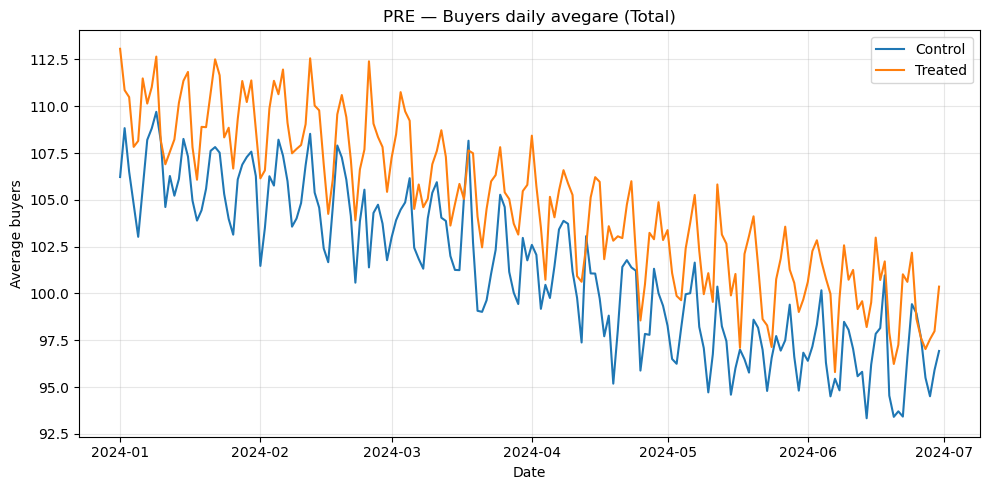

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3202101597.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w"]))


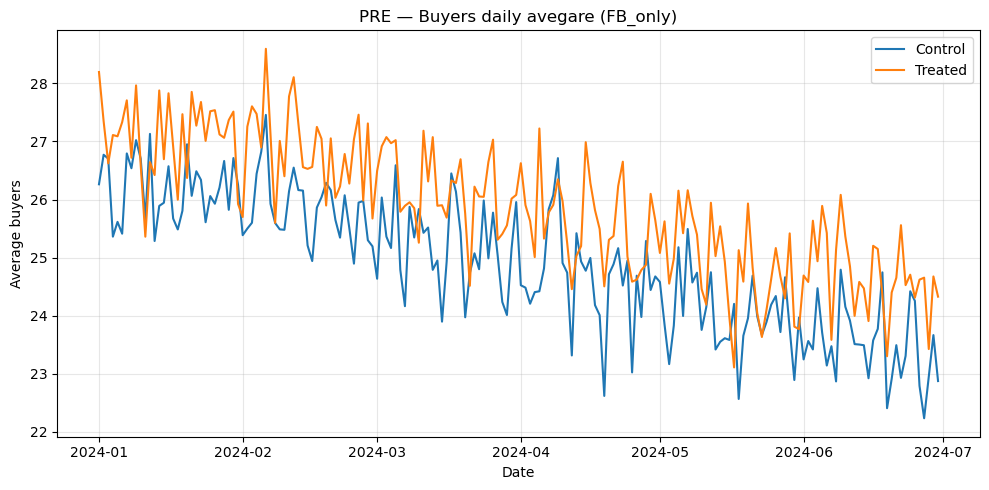

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3202101597.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w"]))


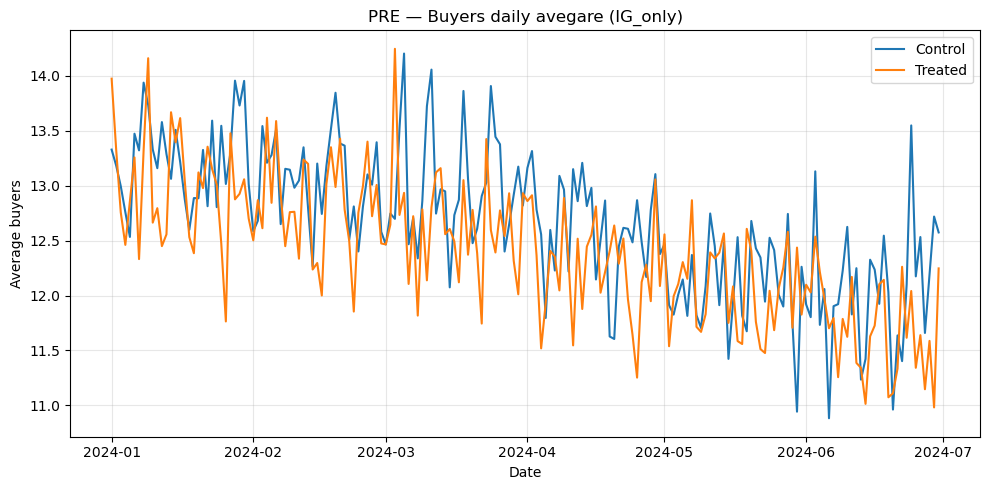

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3202101597.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w"]))


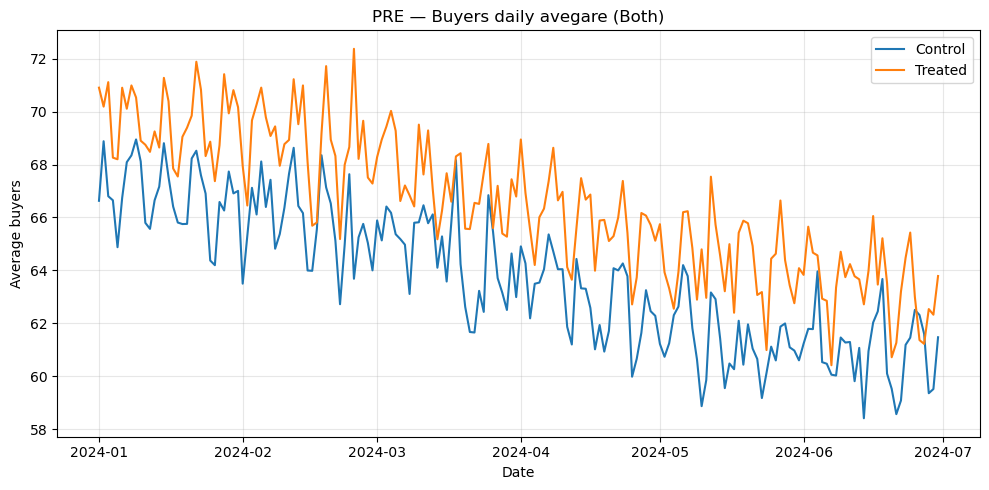

In [47]:
def plot_pre_series(panel_pre, value_col, title):
    daily = (panel_pre.groupby(["date","treated"])
                    .apply(lambda d: np.average(d[value_col], weights=d["w"]))
                    .reset_index(name="avg"))
    plt.figure(figsize=(10,5))
    for t,label in zip([0,1],["Control","Treated"]):
        s = daily[daily["treated"]==t]
        plt.plot(s["date"], s["avg"], label=label)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Average buyers")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pre_series(panel_bal[panel_bal["period"] == "pre"], "total_buyers",
                "PRE — Buyers daily avegare (Total)")
plot_pre_series(panel_bal[panel_bal["period"] == "pre"], "fb_only_buyers",
                "PRE — Buyers daily avegare (FB_only)")
plot_pre_series(panel_bal[panel_bal["period"] == "pre"], "ig_only_buyers",
                "PRE — Buyers daily avegare (IG_only)")
plot_pre_series(panel_bal[panel_bal["period"] == "pre"], "both_buyers",
                "PRE — Buyers daily avegare (Both)")

Imagine the experiment is now done. How do you infer the effects from the collected data?

In [48]:
panel_bal.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx,market_trend,geo_mult,day_noise,slope_mult,fb_only_buyers,ig_only_buyers,both_buyers,total_buyers,period,w,treated,w_treated,w_control
0,2024-01-01,city_000,40490,14799,63193,118482,0,1.07,1.033774,0.999033,0.998790,29,9,40,78,pre,0.004646,0,0.000000,0.009199
1,2024-01-01,city_001,39857,14825,62667,117349,0,1.07,0.969790,1.023729,1.013706,19,9,68,96,pre,0.004602,0,0.000000,0.009111
2,2024-01-01,city_002,62508,22651,103735,188894,0,1.07,0.945220,1.012470,0.986455,33,15,88,136,pre,0.007407,1,0.014966,0.000000
3,2024-01-01,city_003,70936,25904,106697,203537,0,1.07,0.948957,1.016384,1.004981,30,15,82,127,pre,0.007981,0,0.000000,0.015802
4,2024-01-01,city_004,10380,3388,14915,28683,0,1.07,0.981868,1.007836,1.017351,6,1,18,25,pre,0.001125,0,0.000000,0.002227


In [49]:
# =========================
# 3) Effects
# =========================

# Lifts to apply only to treated cities in post periods
LIFT_FB   = 0.10 
LIFT_IG   = 0.12
LIFT_BOTH = 0.15

panel_exp = panel_bal.copy()

mask_post_treated = (panel_exp["period"] == "post") & (panel_exp["treated"] == 1)

panel_exp["fb_only_buyers_post"] = panel_exp["fb_only_buyers"]
panel_exp["ig_only_buyers_post"] = panel_exp["ig_only_buyers"]
panel_exp["both_buyers_post"]    = panel_exp["both_buyers"]

panel_exp.loc[mask_post_treated, "fb_only_buyers_post"] *= (1 + LIFT_FB)
panel_exp.loc[mask_post_treated, "ig_only_buyers_post"] *= (1 + LIFT_IG)
panel_exp.loc[mask_post_treated, "both_buyers_post"]    *= (1 + LIFT_BOTH)

# Total post
panel_exp["total_buyers_post"] = panel_exp["fb_only_buyers_post"] + panel_exp["ig_only_buyers_post"] + panel_exp["both_buyers_post"]

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3681168000.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[33.   8.8 36.3 ... 31.9 25.3 48.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  panel_exp.loc[mask_post_treated, "fb_only_buyers_post"] *= (1 + LIFT_FB)
C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3681168000.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[17.92  3.36 16.8  ... 13.44  8.96 16.8 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  panel_exp.loc[mask_post_treated, "ig_only_buyers_post"] *= (1 + LIFT_IG)
C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\3681168000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[81.6

In [50]:
panel_exp.head()

,date,city,fb_only_users,ig_only_users,both_users,total_users,day_idx,market_trend,geo_mult,day_noise,...,total_buyers,period,w,treated,w_treated,w_control,fb_only_buyers_post,ig_only_buyers_post,both_buyers_post,total_buyers_post
0,2024-01-01,city_000,40490,14799,63193,118482,0,1.07,1.033774,0.999033,...,78,pre,0.004646,0,0.000000,0.009199,29.0,9.0,40.0,78.0
1,2024-01-01,city_001,39857,14825,62667,117349,0,1.07,0.969790,1.023729,...,96,pre,0.004602,0,0.000000,0.009111,19.0,9.0,68.0,96.0
2,2024-01-01,city_002,62508,22651,103735,188894,0,1.07,0.945220,1.012470,...,136,pre,0.007407,1,0.014966,0.000000,33.0,15.0,88.0,136.0
3,2024-01-01,city_003,70936,25904,106697,203537,0,1.07,0.948957,1.016384,...,127,pre,0.007981,0,0.000000,0.015802,30.0,15.0,82.0,127.0
4,2024-01-01,city_004,10380,3388,14915,28683,0,1.07,0.981868,1.007836,...,25,pre,0.001125,0,0.000000,0.002227,6.0,1.0,18.0,25.0


In [52]:
# DiD
def wavg(series, weights):
    return np.average(series, weights=weights)

def did_for_column(df, col):
    pre  = df[df["period"] == "pre"]
    post = df[df["period"] == "post"]

    pre_t  = wavg(pre.loc[pre.treated==1,  col], pre.loc[pre.treated==1,  "w_"])
    pre_c  = wavg(pre.loc[pre.treated==0,  col], pre.loc[pre.treated==0,  "w_"])
    post_t = wavg(post.loc[post.treated==1, col], post.loc[post.treated==1, "w_"])
    post_c = wavg(post.loc[post.treated==0, col], post.loc[post.treated==0, "w_"])

    did = (post_t - post_c) - (pre_t - pre_c)
    return pre_t, pre_c, post_t, post_c, did

outcomes = {
    "total": "total_buyers_post",
    "fb_only": "fb_only_buyers_post",
    "ig_only": "ig_only_buyers_post",
    "both": "both_buyers_post",
}


# to facilitate calculation
panel_exp["w_"] = np.where(panel_exp["treated"] == 1,
                          panel_exp["w_treated"],
                          panel_exp["w_control"])



rows = []
for name, col in outcomes.items():
    pre_t, pre_c, post_t, post_c, did = did_for_column(panel_exp, col)
    rows.append({
        "outcome": name,
        "pre_t": pre_t, "pre_c": pre_c,
        "post_t": post_t, "post_c": post_c,
        "DiD_estimate": did
    })

effects = pd.DataFrame(rows)
print(effects)

   outcome       pre_t       pre_c      post_t      post_c  DiD_estimate
0    total  104.854114  101.326508  118.625686  101.461414     13.636665
1  fb_only   25.873566   24.892916   28.353370   24.867413      2.505307
2  ig_only   12.407048   12.672845   13.798175   12.688517      1.375455
3     both   66.573501   63.760747   76.474141   63.905484      9.755904


**Conclusion**: before the campaign, the treated and control groups had similar average numbers of buyers. After the campaign, the treated group showed and increase of about 13.6 buyers per day.

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\2933339237.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w_"]))


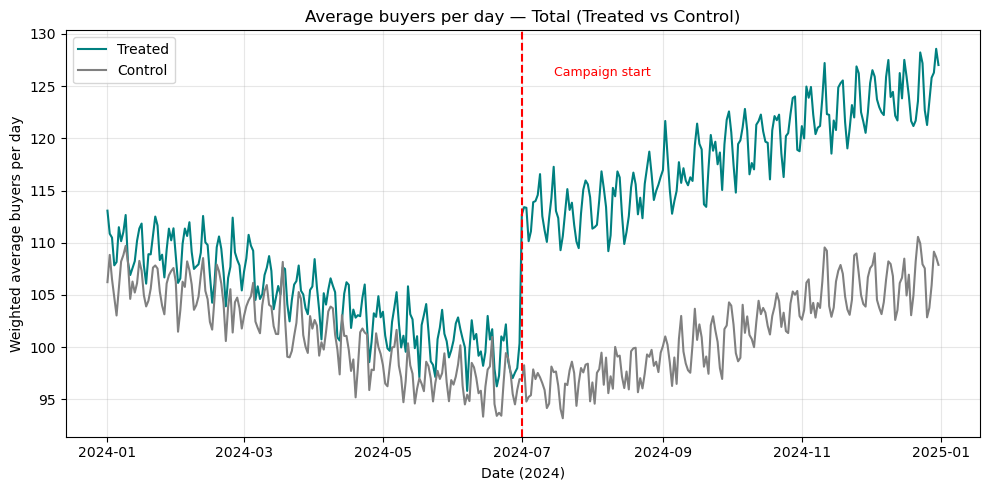

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\2933339237.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w_"]))


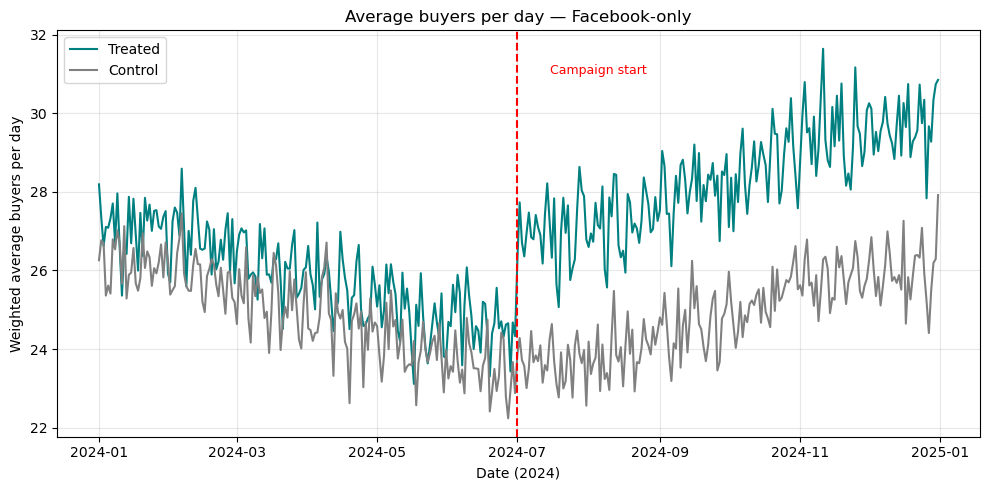

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\2933339237.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w_"]))


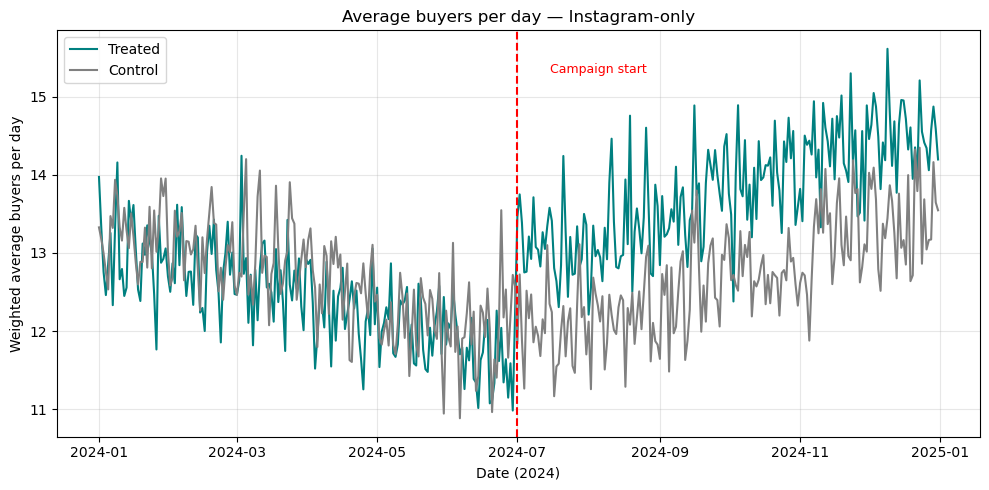

C:\Users\gabim\AppData\Local\Temp\ipykernel_24872\2933339237.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d[value_col], weights=d["w_"]))


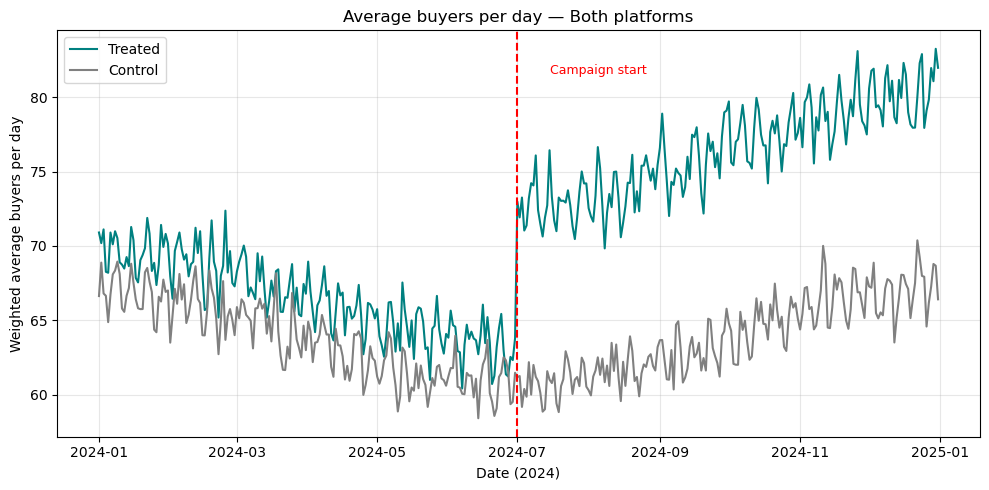

In [ ]:
def plot_time_series(df, value_col, title):
    daily = (df.groupby(["date","treated"])
               .apply(lambda d: np.average(d[value_col], weights=d["w_"]))
               .reset_index(name="avg"))
    
    treated = daily[daily["treated"] == 1]
    control = daily[daily["treated"] == 0]

    plt.figure(figsize=(10,5))
    plt.plot(treated["date"], treated["avg"], label="Treated", color="teal")
    plt.plot(control["date"], control["avg"], label="Control", color="gray")

    plt.axvline(pd.Timestamp("2024-07-01"), color="red", linestyle="--", lw=1.5)
    plt.text(pd.Timestamp("2024-07-15"), treated["avg"].max()*0.98,
             "Campaign start", color="red", fontsize=9)

    plt.title(title)
    plt.xlabel("Date (2024)")
    plt.ylabel("Weighted average buyers per day")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_time_series(panel_exp, "total_buyers_post",
                 "Average buyers per day — Total (Treated vs Control)")
plot_time_series(panel_exp, "fb_only_buyers_post",
                 "Average buyers per day — Facebook-only")
plot_time_series(panel_exp, "ig_only_buyers_post",
                 "Average buyers per day — Instagram-only")
plot_time_series(panel_exp, "both_buyers_post",
                 "Average buyers per day — Both platforms")
